In [8]:
import math
from functools import cache

import numpy as np

In [9]:
def binomial(n, k):
    result = 1
    for i in range(1, k+1):
        result *= n - i + 1
        result /= i
    return result


def prob(n, k, p):
    return p**k * (1-p)**(n-k) * binomial(n, k)


@cache
def probge(n, k, p):
    return sum(prob(n, i, p) for i in range(k, n+1))

In [13]:
CUR_VALIDATORS = 664_205

def safe_percentage_malicious_validators(kp):
    '''
    Given a SC majority we want to see confirming a block, we can
    compute how many malicious validators (as a percentage) we can
    tolerate as having a negligible chance of corruption.

    This function approximates the following inequation:
    sum(
        (p^k * (1-p)^(n-k) * binomial(n, k))
        for k in range(342, 512+1)
    ) < 2^(-80).

    If you can compute this analytically, please drop a comment.
    '''
    e = 2**(-80)
    k = math.ceil(512 * kp)
    
    def bounds():
        a = None
        for b in np.linspace(0, 1, 2**10):
            cond = probge(512, k, b) < e
            if not cond:
                break
            a = b
        return a, b

    a, b = bounds()
    safe = None
    for p in np.linspace(a, b, 2**10):
        cond = probge(512, k, p) < e
        if not cond:
            break
        safe = p

    return safe

262144


In [11]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm

In [12]:
SLOTS_PER_EPOCH = 32
MAX_COMMITTEES_PER_SLOT = 64
MAX_VALIDATORS_PER_COMMITTEE = 2048
MIN_PER_EPOCH_CHURN_LIMIT = 4
CHURN_LIMIT_QUOTIENT = 65536

In [13]:
def get_validator_churn_limit(n):
    '''
    n: number of active validators
    '''
    # NOTE: The churn limit is an integer, but
    # we use a FP number here to smooth the plot.
    return max(MIN_PER_EPOCH_CHURN_LIMIT, n / CHURN_LIMIT_QUOTIENT)

In [14]:
def eeks_to_exit(num_validators, fraction):
    '''
    Given a number of validators, returns how many eeks are needed
    for a `fraction` of them to exit the system at the current churn
    limit.

    NB: This function does not take into account the decreasing churn
        limit, thus giving shorter prediction (which in our case
        means also "safer"), nor does it take into account the
        MIN_VALIDATOR_WITHDRAWABILITY_DELAY (== 256 epochs, ~27 h).
    '''
    return num_validators / get_validator_churn_limit(num_validators) * fraction / 2048

In [21]:
def eeks_to_days(eeks):
    MINUTES_PER_EPOCH = 6.4
    return eeks * 2048 * MINUTES_PER_EPOCH / 60 / 24

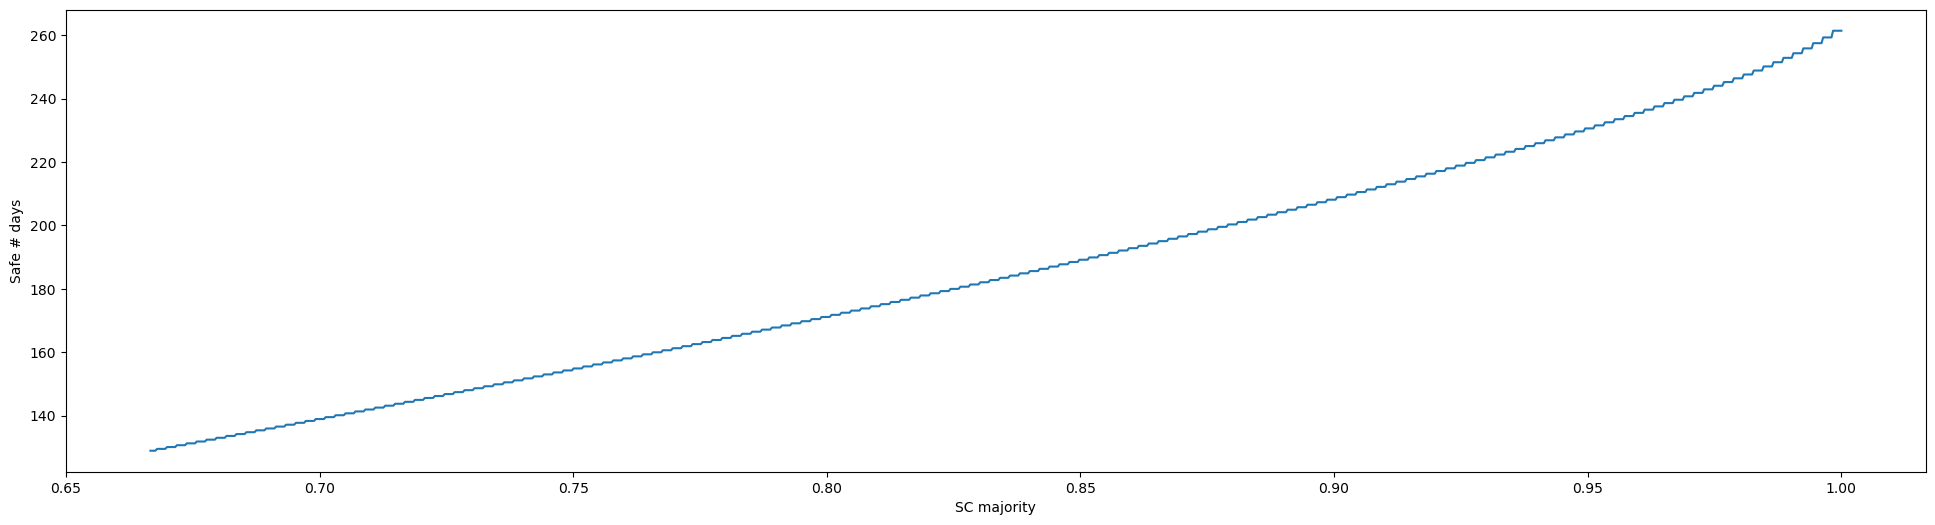

In [38]:
def f():
    xs = np.linspace(2/3, 1, 1024)
    ys = []
    for kp in xs:
        safe = safe_percentage_malicious_validators(kp)
        y = eeks_to_exit(2**18, safe)
        ys.append(y)
    plt.figure(figsize=(24, 6))
    plt.xlabel('SC majority')
    plt.ylabel('Safe # days')
    plt.plot(xs, [eeks_to_days(y) for y in ys])
    plt.savefig('majority-safedays.png')
    plt.show()
f()

In [55]:
def f():
    xs = [2/3, .7, .75, .8, .85, .9, .95]
    ys = []
    for kp in xs:
        safe = safe_percentage_malicious_validators(kp)
        y = eeks_to_exit(2**18, safe)
        ys.append(y)
    zs = pd.DataFrame({
        'SCMajority': xs,
        'SafeEeks': ys,
    })
    zs['SafeDays'] = zs.SafeEeks.map(eeks_to_days)
    zs.SCMajority = zs.SCMajority.mul(100).map(str) + '%'
    table = zs.to_markdown()
    print(table)
f()

|    | SCMajority         |   SafeEeks |   SafeDays |
|---:|:-------------------|-----------:|-----------:|
|  0 | 66.66666666666666% |    14.165  |    128.933 |
|  1 | 70.0%              |    15.2628 |    138.925 |
|  2 | 75.0%              |    16.9462 |    154.248 |
|  3 | 80.0%              |    18.7985 |    171.108 |
|  4 | 85.0%              |    20.7817 |    189.16  |
|  5 | 90.0%              |    22.8615 |    208.091 |
|  6 | 95.0%              |    25.3308 |    230.566 |
